In [3]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb
import optuna
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from main import *

In [12]:
# Random Seed
random_state = 33
np.random.seed(random_state)

In [13]:
# plt style
plt.style.use("seaborn-v0_8-darkgrid")

### Dataset

In [4]:
# Dataset
PROJECT_DIR, df = get_combined_df()
df.head()


,flight_id,before_after,date_diff,flight_length,label,num_flights_before,volt1_mean,volt1_std,volt1_min,volt1_max,...,E1_CHT_cruise_stability,E1_RPM_cruise_stability,E1_OilP_RPM_corr,E1_CHT2_CHT4_corr,E1_EGT1_EGT3_corr,fuel_imbalance_trend,E1_CHT_p90_p10_spread,E1_EGT_p90_p10_spread,E1_CHT_asymmetry,E1_CHT_spread_p90
0,1,before,-1,4723.0,intake gasket leak/damage,-1,28.780796,4.712894e-02,28.7,29.3,...,NaN,135.360540,0.928213,NaN,0.991630,0.000837,NaN,442.29050,NaN,NaN
1,2,before,-2,4649.0,intake gasket leak/damage,-2,27.831276,7.633934e-01,25.0,28.2,...,20.371883,222.531540,0.973778,0.921516,0.996713,0.000105,97.8160,508.72900,0.639139,40.692
2,3,same,0,40.0,intake gasket leak/damage,0,24.900000,3.600403e-15,24.9,24.9,...,NaN,NaN,NaN,NaN,0.981069,-0.002973,NaN,0.12425,NaN,NaN
3,4,before,0,14.0,intake gasket leak/damage,0,25.400000,3.697782e-15,25.4,25.4,...,NaN,NaN,NaN,0.982345,0.961690,NaN,0.2940,0.23050,0.163636,11.910
4,5,same,0,683.0,intake gasket leak/damage,0,26.945095,1.271312e+00,24.6,28.1,...,73.223720,451.412721,0.941312,0.997425,0.998258,-0.000924,195.6855,419.10500,0.903723,11.694


In [5]:
# add cluster (target) column
json_path = PROJECT_DIR / "data" / "label_cluster_map.json"
assert json_path.exists()

with json_path.open() as fp:
    label_cluster_map = json.loads(fp.read())

df["cluster"] = df["label"].map(label_cluster_map)

In [6]:
# weighted labels
sort_by = "weight_total_impact"

weighted_labels_path = PROJECT_DIR / "data" / "weighted_labels.csv"
weighted_labels_df = pd.read_csv(weighted_labels_path, index_col=0)
weighted_labels_df.sort_values(by=sort_by, ascending=False).head()

,label,count,price_usd,weight_norm,weight_total_impact,risk_factor,weight_risk_factor
7,engine run rough,670,839.99,0.383613,562793.30,1.4,27185.660955
3,baffle crack/damage/loose/miss,1294,419.95,0.237344,543415.30,1.3,34472.789022
9,engine failure/fire/time out,643,839.99,0.382277,540113.57,2.0,37271.599134
10,cylinder compression issue,617,795.00,0.362015,490515.00,1.7,29574.516259
17,oil cooler need maintenance,312,1189.00,0.513092,370968.00,1.4,15061.684878


In [7]:
# limit labels and apply filters
num_labels = 5

LABELS = weighted_labels_df.sort_values(by=sort_by, ascending=False)["label"].values[
    :num_labels
]
label_mask = df["label"].isin(LABELS)

# look only at flights before maintenance
before_mask = df["before_after"] == "before"

df_before = df[label_mask & before_mask]

#### Label Distribution

In [8]:
y_full = df_before["cluster"]
class_counts = y_full.value_counts().sort_index()
for cluster in class_counts.index:
    count = class_counts[cluster]
    pct = count / len(y_full) * 100
    print(f"{cluster=}, {pct=:0.2f}")

cluster=4, pct=35.93
cluster=13, pct=19.91
cluster=21, pct=15.56
cluster=24, pct=20.50
cluster=32, pct=8.11


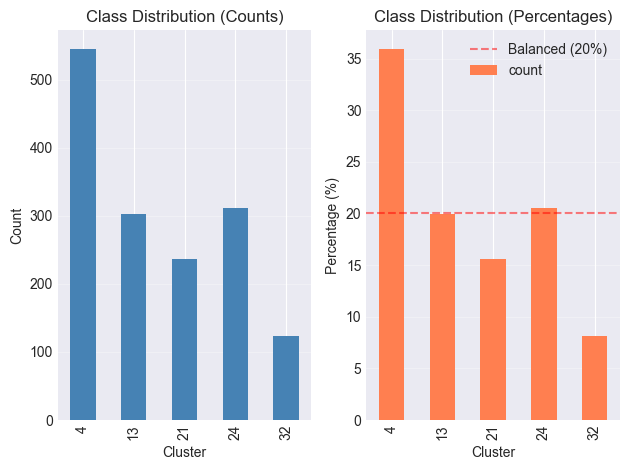

imbalance_ratio=4.43


In [10]:
# Visualize
fig, ax = plt.subplots(1, 2)
class_counts.plot(kind="bar", ax=ax[0], color="steelblue")
ax[0].set_title("Class Distribution (Counts)")
ax[0].set_xlabel("Cluster")
ax[0].set_ylabel("Count")
ax[0].grid(axis="y", alpha=0.3)

class_pcts = class_counts / len(y_full) * 100
class_pcts.plot(kind="bar", ax=ax[1], color="coral")
ax[1].set_title("Class Distribution (Percentages)")
ax[1].set_xlabel("Cluster")
ax[1].set_ylabel("Percentage (%)")
ax[1].axhline(y=20, linestyle="--", color="red", alpha=0.5, label="Balanced (20%)")
ax[1].legend()
ax[1].grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# imbalance ratio
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"{imbalance_ratio=:.2f}")

In [11]:
# Choose features for training
all_features = [
    "AltMSL_max",
    "AltMSL_mean",
    "AltMSL_min",
    "AltMSL_p25",
    "AltMSL_p75",
    "AltMSL_range",
    "AltMSL_rate_mean",
    "AltMSL_std",
    "E1_CHT1_max",
    "E1_CHT1_mean",
    "E1_CHT1_min",
    "E1_CHT1_p25",
    "E1_CHT1_p75",
    "E1_CHT1_std",
    "E1_CHT2_max",
    "E1_CHT2_mean",
    "E1_CHT2_min",
    "E1_CHT2_p25",
    "E1_CHT2_p75",
    "E1_CHT2_std",
    "E1_CHT3_max",
    "E1_CHT3_mean",
    "E1_CHT3_min",
    "E1_CHT3_p25",
    "E1_CHT3_p75",
    "E1_CHT3_std",
    "E1_CHT4_max",
    "E1_CHT4_mean",
    "E1_CHT4_min",
    "E1_CHT4_p25",
    "E1_CHT4_p75",
    "E1_CHT4_std",
    "E1_CHT_max_all",
    "E1_CHT_mean_all",
    "E1_CHT_min_all",
    "E1_CHT_rate_max",
    "E1_CHT_spread_mean",
    "E1_CHT_std_all",
    "E1_EGT1_max",
    "E1_EGT1_mean",
    "E1_EGT1_min",
    "E1_EGT1_p25",
    "E1_EGT1_p75",
    "E1_EGT1_std",
    "E1_EGT2_max",
    "E1_EGT2_mean",
    "E1_EGT2_min",
    "E1_EGT2_p25",
    "E1_EGT2_p75",
    "E1_EGT2_std",
    "E1_EGT3_max",
    "E1_EGT3_mean",
    "E1_EGT3_min",
    "E1_EGT3_p25",
    "E1_EGT3_p75",
    "E1_EGT3_std",
    "E1_EGT4_max",
    "E1_EGT4_mean",
    "E1_EGT4_min",
    "E1_EGT4_p25",
    "E1_EGT4_p75",
    "E1_EGT4_std",
    "E1_EGT_max_all",
    "E1_EGT_mean_all",
    "E1_EGT_min_all",
    "E1_EGT_rate_max",
    "E1_EGT_spread_mean",
    "E1_EGT_std_all",
    "E1_FFlow_max",
    "E1_FFlow_mean",
    "E1_FFlow_min",
    "E1_FFlow_p25",
    "E1_FFlow_p75",
    "E1_FFlow_std",
    "E1_OilP_mean",
    "E1_OilP_min",
    "E1_OilP_p25",
    "E1_OilP_p75",
    "E1_OilP_std",
    "E1_OilT_max",
    "E1_OilT_mean",
    "E1_OilT_min",
    "E1_OilT_p25",
    "E1_OilT_p75",
    "E1_OilT_rate",
    "E1_OilT_std",
    "E1_RPM_max",
    "E1_RPM_mean",
    "E1_RPM_min",
    "E1_RPM_p25",
    "E1_RPM_p75",
    "E1_RPM_std",
    "FQtyL_consumed",
    "FQtyL_end",
    "FQtyL_max",
    "FQtyL_mean",
    "FQtyL_min",
    "FQtyL_p25",
    "FQtyL_p75",
    "FQtyL_rate",
    "FQtyL_start",
    "FQtyL_std",
    "FQtyR_consumed",
    "FQtyR_end",
    "FQtyR_max",
    "FQtyR_mean",
    "FQtyR_min",
    "FQtyR_p25",
    "FQtyR_p75",
    "FQtyR_rate",
    "FQtyR_start",
    "FQtyR_std",
    "IAS_max",
    "IAS_mean",
    "IAS_min",
    "IAS_p25",
    "IAS_p75",
    "IAS_rate_mean",
    "IAS_std",
    "NormAc_max",
    "NormAc_mean",
    "NormAc_min",
    "NormAc_p25",
    "NormAc_p75",
    "NormAc_std",
    "OAT_max",
    "OAT_mean",
    "OAT_min",
    "OAT_p25",
    "OAT_p75",
    "OAT_std",
    "VSpd_max",
    "VSpd_mean",
    "VSpd_min",
    "VSpd_p25",
    "VSpd_p75",
    "VSpd_std",
    "amp1_max",
    "amp1_mean",
    "amp1_min",
    "amp1_p25",
    "amp1_p75",
    "amp1_std",
    "amp2_max",
    "amp2_mean",
    "amp2_min",
    "amp2_p25",
    "amp2_p75",
    "amp2_std",
    # "date_diff",
    # "flight_length",
    "fuel_imbalance_max",
    "fuel_imbalance_mean",
    # "num_flights_before",
    "volt1_max",
    "volt1_mean",
    "volt1_min",
    "volt1_p25",
    "volt1_p75",
    "volt1_std",
    "volt2_max",
    "volt2_mean",
    "volt2_min",
    "volt2_p25",
    "volt2_p75",
    "volt2_std",
]

In [12]:
# Split into X, y with all features
X_all = df_before[all_features].copy()
y_all = df_before["cluster"].copy()


le = LabelEncoder()
y_all_encoded = le.fit_transform(y_all)


# Remove rows with any NaN values
nan_mask = ~X_all.isna().any(axis=1)
X = X_all[nan_mask]
y = y_all_encoded[nan_mask]

# Check for NaN, inf
assert not X.isna().any().any()
assert not np.isinf(X).any().any()

### Train-Test Split

In [13]:
# train-test split with stratification
test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_size,
    random_state=random_state,
    stratify=y,
)

In [14]:
X_train.shape

(1054, 163)

In [15]:
X_train.isna().any().any()

np.False_

In [16]:
X_test.isna().any().any()

np.False_

### Feature Importance

#### F-Score

In [17]:
# f-stats - variance between means of different clusters
# higher f-value indicates greater effectiveness at separating cluster
f_scores, f_pvalues = f_classif(X_train, y_train)
f_scores_df = pd.DataFrame(
    {"feature": X_train.columns, "f_score": f_scores, "p_value": f_pvalues}
).sort_values("f_score", ascending=False)

print(f_scores_df.head(10))

          feature   f_score   p_value
100   FQtyL_start  7.525347  0.000006
94      FQtyL_max  7.414836  0.000007
0      AltMSL_max  7.167822  0.000011
130       OAT_std  7.127102  0.000012
5    AltMSL_range  7.061898  0.000013
7      AltMSL_std  7.035048  0.000014
1     AltMSL_mean  6.880226  0.000018
4      AltMSL_p75  6.747776  0.000023
104     FQtyR_max  6.186885  0.000064
146      amp2_p25  5.842406  0.000119


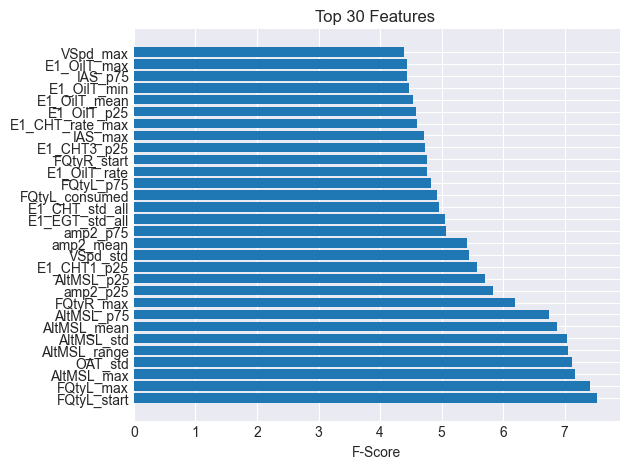

In [18]:
# Visualize top features
num_features = 30

top_df = f_scores_df.iloc[:num_features, :]
plt.barh(y=top_df["feature"], width=top_df["f_score"])

# f_scores_df.head(30).plot(x='feature', y='f_score', kind='barh', ax=ax, color='steelblue')
plt.title(f"Top {num_features} Features ")
plt.xlabel("F-Score")
plt.tight_layout()
plt.show()

#### Mutual Information

In [19]:
# Mutual Information - quantifies dependency between each individual feature X and target y
# Higher score indicate stronger dependency
mi_scores = mutual_info_classif(
    X_train, y_train, random_state=random_state, n_neighbors=5
)
mi_scores_df = pd.DataFrame(
    {"feature": X_train.columns, "mi_score": mi_scores}
).sort_values("mi_score", ascending=False)

print(mi_scores_df.head(10))


            feature  mi_score
144       amp2_mean  0.074308
140        amp1_p25  0.072776
29      E1_CHT4_p25  0.070655
9      E1_CHT1_mean  0.052019
126        OAT_mean  0.046774
23      E1_CHT3_p25  0.046680
94        FQtyL_max  0.044704
37   E1_CHT_std_all  0.044695
107       FQtyR_p25  0.044205
124      NormAc_std  0.043098


Text(0.5, 0, 'Mutual Information Score')

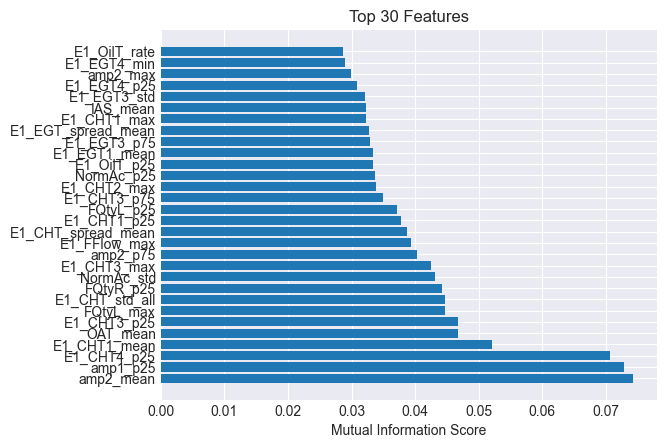

In [20]:
# Visualize top features
top_df = mi_scores_df.iloc[:num_features, :]

plt.barh(y=top_df["feature"], width=top_df["mi_score"])
plt.title(f"Top {num_features} Features")
plt.xlabel("Mutual Information Score")

#### Baseline Model Feature Importance

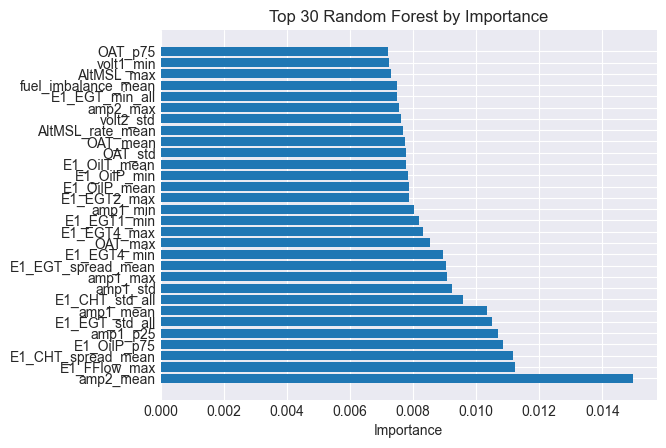

In [21]:
rf_baseline = RandomForestClassifier(
    n_estimators=100, class_weight="balanced", random_state=random_state, n_jobs=-1
)
rf_baseline.fit(X_train, y_train)

rf_importance_df = pd.DataFrame(
    {"feature": X_train.columns, "importance": rf_baseline.feature_importances_}
).sort_values("importance", ascending=False)

# plot
top_df = rf_importance_df.iloc[:num_features, :]
plt.barh(y=top_df["feature"], width=top_df["importance"])
plt.title(f"Top {num_features} Random Forest by Importance")
plt.xlabel("Importance");

#### Combined Feature Ranking

In [22]:
combined_df = pd.DataFrame({"feature": X_train.columns})
combined_df = combined_df.merge(f_scores_df[["feature", "f_score"]], on="feature")
combined_df = combined_df.merge(mi_scores_df[["feature", "mi_score"]], on="feature")
combined_df = combined_df.merge(
    rf_importance_df[["feature", "importance"]], on="feature"
)
combined_df.head()

,feature,f_score,mi_score,importance
0,AltMSL_max,7.167822,0.018790,0.007291
1,AltMSL_mean,6.880226,0.022074,0.004994
2,AltMSL_min,0.492570,0.002076,0.005959
3,AltMSL_p25,5.708153,0.013280,0.005041
4,AltMSL_p75,6.747776,0.025343,0.005344


In [23]:
# Normalize each score
scaler = MinMaxScaler()
combined_df["f_score_norm"] = scaler.fit_transform(combined_df[["f_score"]])
combined_df["mi_score_norm"] = scaler.fit_transform(combined_df[["mi_score"]])
combined_df["importance_norm"] = scaler.fit_transform(combined_df[["importance"]])

# Calculate average rank
combined_df["avg_score"] = combined_df[
    ["f_score_norm", "mi_score_norm", "importance_norm"]
].mean(axis=1)
combined_df = combined_df.sort_values("avg_score", ascending=False)
combined_df.head(10)


,feature,f_score,mi_score,importance,f_score_norm,mi_score_norm,importance_norm,avg_score
144,amp2_mean,5.421873,0.074308,0.014982,0.719559,1.000000,1.000000,0.906520
37,E1_CHT_std_all,4.965345,0.044695,0.009569,0.658693,0.601484,0.599161,0.619779
29,E1_CHT4_p25,3.950278,0.070655,0.006262,0.523362,0.950836,0.354207,0.609468
94,FQtyL_max,7.414836,0.044704,0.003595,0.985266,0.601597,0.156711,0.581191
140,amp1_p25,0.616590,0.072776,0.010705,0.078905,0.979383,0.683264,0.580517
36,E1_CHT_spread_mean,3.287830,0.038710,0.011181,0.435042,0.520931,0.718480,0.558151
5,AltMSL_range,7.061898,0.022414,0.007043,0.938212,0.301639,0.412080,0.550644
100,FQtyL_start,7.525347,0.022243,0.006049,1.000000,0.299331,0.338439,0.545923
0,AltMSL_max,7.167822,0.018790,0.007291,0.952334,0.252870,0.430420,0.545208
67,E1_EGT_std_all,5.050804,0.019736,0.010508,0.670087,0.265596,0.668638,0.534774


### Model Tuning

In [27]:
# Select top features based on combined ranking
num_features = 23  # number of sensors

# selected features
features = combined_df.head(num_features)["feature"].tolist()

# Create reduced feature sets
X_train_reduced = X_train[features]
X_test_reduced = X_test[features]

features_path = PROJECT_DIR / "models" / "selected_features.json"
with open(features_path) as f:
    optimal_features = json.load(f)

X_train_optimal = X_train[optimal_features]
X_test_optimal = X_test[optimal_features]

# Number of unique classes
num_classes = len(np.unique(y_train))

### Find Optimal Features

In [28]:
def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": num_classes,
        "learning_rate": trial.suggest_float("lr", 0.005, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 32, 256),
        "max_depth": trial.suggest_int("max_depth", -1, 16),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 60),
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 5),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 5),
        "is_unbalance": True,
        "metric": "multi_logloss",
        "verbose": -1,
    }

    model = lgb.train(
        params,
        lgb.Dataset(X_train_optimal, label=y_train),
        valid_sets=[lgb.Dataset(X_test_optimal, label=y_test)],
        num_boost_round=2000,
        callbacks=[lgb.early_stopping(100)],
    )

    preds = model.predict(X_test_optimal)
    pred_labels = np.argmax(preds, axis=1)

    return f1_score(y_test, pred_labels, average="macro")


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_trial.params)
print("Best macro F1:", study.best_value)

[I 2025-11-28 16:10:16,467] A new study created in memory with name: no-name-d9039833-67a7-4100-8d2a-76d8917521ed


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[697]	valid_0's multi_logloss: 1.05754


[I 2025-11-28 16:10:19,084] Trial 0 finished with value: 0.5359040152280314 and parameters: {'lr': 0.03045867630915855, 'num_leaves': 76, 'max_depth': 12, 'feature_fraction': 0.9622292590575947, 'bagging_fraction': 0.7924730687113537, 'bagging_freq': 8, 'min_data_in_leaf': 24, 'lambda_l1': 3.544903811543782, 'lambda_l2': 3.511772004396008}. Best is trial 0 with value: 0.5359040152280314.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[714]	valid_0's multi_logloss: 1.03354


[I 2025-11-28 16:10:20,733] Trial 1 finished with value: 0.5621887460333903 and parameters: {'lr': 0.06558614073696857, 'num_leaves': 253, 'max_depth': 5, 'feature_fraction': 0.753665637704279, 'bagging_fraction': 0.9577880235572558, 'bagging_freq': 2, 'min_data_in_leaf': 59, 'lambda_l1': 1.945230994126716, 'lambda_l2': 4.760558173978848}. Best is trial 1 with value: 0.5621887460333903.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's multi_logloss: 1.01562


[I 2025-11-28 16:10:26,035] Trial 2 finished with value: 0.558452005422836 and parameters: {'lr': 0.01008208044639285, 'num_leaves': 153, 'max_depth': 5, 'feature_fraction': 0.7629885843935305, 'bagging_fraction': 0.5593306517761192, 'bagging_freq': 9, 'min_data_in_leaf': 24, 'lambda_l1': 0.10363253569850628, 'lambda_l2': 3.2356541459398276}. Best is trial 1 with value: 0.5621887460333903.


Training until validation scores don't improve for 100 rounds


[I 2025-11-28 16:10:28,022] Trial 3 finished with value: 0.5855968440377076 and parameters: {'lr': 0.04943509192542301, 'num_leaves': 146, 'max_depth': 6, 'feature_fraction': 0.7279225205160935, 'bagging_fraction': 0.9254851694608165, 'bagging_freq': 5, 'min_data_in_leaf': 10, 'lambda_l1': 1.5225918485572887, 'lambda_l2': 2.5700133154020417}. Best is trial 3 with value: 0.5855968440377076.


Early stopping, best iteration is:
[325]	valid_0's multi_logloss: 0.974539
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[474]	valid_0's multi_logloss: 1.06553


[I 2025-11-28 16:10:31,831] Trial 4 finished with value: 0.549611368588067 and parameters: {'lr': 0.08879266078761767, 'num_leaves': 50, 'max_depth': 6, 'feature_fraction': 0.9355976692506034, 'bagging_fraction': 0.7610280018804088, 'bagging_freq': 6, 'min_data_in_leaf': 15, 'lambda_l1': 3.345723597543521, 'lambda_l2': 4.700735440206282}. Best is trial 3 with value: 0.5855968440377076.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[377]	valid_0's multi_logloss: 1.00149


[I 2025-11-28 16:10:35,124] Trial 5 finished with value: 0.5727200698742821 and parameters: {'lr': 0.0656206068338175, 'num_leaves': 209, 'max_depth': 15, 'feature_fraction': 0.9219608230181816, 'bagging_fraction': 0.7583194248683194, 'bagging_freq': 9, 'min_data_in_leaf': 25, 'lambda_l1': 1.6842672484102446, 'lambda_l2': 4.337917446190448}. Best is trial 3 with value: 0.5855968440377076.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1155]	valid_0's multi_logloss: 0.97724


[I 2025-11-28 16:10:42,396] Trial 6 finished with value: 0.596998429484358 and parameters: {'lr': 0.018707561508897786, 'num_leaves': 131, 'max_depth': 11, 'feature_fraction': 0.8080909110412953, 'bagging_fraction': 0.890589007641376, 'bagging_freq': 3, 'min_data_in_leaf': 25, 'lambda_l1': 2.029475079749443, 'lambda_l2': 3.164776439811644}. Best is trial 6 with value: 0.596998429484358.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1231]	valid_0's multi_logloss: 1.09749


[I 2025-11-28 16:10:48,542] Trial 7 finished with value: 0.5547729801859111 and parameters: {'lr': 0.03614523436044489, 'num_leaves': 131, 'max_depth': 8, 'feature_fraction': 0.9451094556119023, 'bagging_fraction': 0.5344623517841101, 'bagging_freq': 2, 'min_data_in_leaf': 45, 'lambda_l1': 3.2822762903328435, 'lambda_l2': 3.161807879480018}. Best is trial 6 with value: 0.596998429484358.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[786]	valid_0's multi_logloss: 1.05304


[I 2025-11-28 16:10:51,176] Trial 8 finished with value: 0.5866451356862316 and parameters: {'lr': 0.05379240538104325, 'num_leaves': 204, 'max_depth': 12, 'feature_fraction': 0.7430229815136579, 'bagging_fraction': 0.6277137632034927, 'bagging_freq': 6, 'min_data_in_leaf': 48, 'lambda_l1': 2.34129263928295, 'lambda_l2': 3.8951084262584375}. Best is trial 6 with value: 0.596998429484358.


Training until validation scores don't improve for 100 rounds


[I 2025-11-28 16:10:52,682] Trial 9 finished with value: 0.5588439917626761 and parameters: {'lr': 0.0791810525642577, 'num_leaves': 211, 'max_depth': 15, 'feature_fraction': 0.5703466918800639, 'bagging_fraction': 0.8770750242863168, 'bagging_freq': 5, 'min_data_in_leaf': 25, 'lambda_l1': 2.7283579358256955, 'lambda_l2': 0.5336816658387716}. Best is trial 6 with value: 0.596998429484358.


Early stopping, best iteration is:
[289]	valid_0's multi_logloss: 1.05804
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's multi_logloss: 1.14289


[I 2025-11-28 16:10:59,624] Trial 10 finished with value: 0.500442946841658 and parameters: {'lr': 0.00922396851021623, 'num_leaves': 98, 'max_depth': -1, 'feature_fraction': 0.5834500791764294, 'bagging_fraction': 0.8566661943083125, 'bagging_freq': 1, 'min_data_in_leaf': 38, 'lambda_l1': 4.959567263982926, 'lambda_l2': 1.4284987164513034}. Best is trial 6 with value: 0.596998429484358.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[720]	valid_0's multi_logloss: 1.01362


[I 2025-11-28 16:11:02,573] Trial 11 finished with value: 0.55046189979763 and parameters: {'lr': 0.0388307002850521, 'num_leaves': 188, 'max_depth': 11, 'feature_fraction': 0.8388924814569256, 'bagging_fraction': 0.6142443408105887, 'bagging_freq': 4, 'min_data_in_leaf': 47, 'lambda_l1': 0.6450669791817467, 'lambda_l2': 1.940536148271175}. Best is trial 6 with value: 0.596998429484358.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1728]	valid_0's multi_logloss: 1.07955


[I 2025-11-28 16:11:07,999] Trial 12 finished with value: 0.5442164502164503 and parameters: {'lr': 0.020878120683263945, 'num_leaves': 178, 'max_depth': 11, 'feature_fraction': 0.6698304263474392, 'bagging_fraction': 0.6629001107604798, 'bagging_freq': 3, 'min_data_in_leaf': 55, 'lambda_l1': 2.4548232386504707, 'lambda_l2': 3.958681613622962}. Best is trial 6 with value: 0.596998429484358.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[665]	valid_0's multi_logloss: 1.01385


[I 2025-11-28 16:11:10,999] Trial 13 finished with value: 0.5980739261172879 and parameters: {'lr': 0.05485714926123827, 'num_leaves': 107, 'max_depth': 13, 'feature_fraction': 0.8462436043912449, 'bagging_fraction': 0.6915064946161721, 'bagging_freq': 7, 'min_data_in_leaf': 37, 'lambda_l1': 1.1075359889288325, 'lambda_l2': 2.845662282079405}. Best is trial 13 with value: 0.5980739261172879.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	valid_0's multi_logloss: 0.967707


[I 2025-11-28 16:11:13,441] Trial 14 finished with value: 0.6016401896683586 and parameters: {'lr': 0.05597575511575595, 'num_leaves': 106, 'max_depth': 9, 'feature_fraction': 0.8178139913165119, 'bagging_fraction': 0.9978922990151793, 'bagging_freq': 7, 'min_data_in_leaf': 34, 'lambda_l1': 0.8595187221696845, 'lambda_l2': 2.530756941342521}. Best is trial 14 with value: 0.6016401896683586.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[627]	valid_0's multi_logloss: 1.17629


[I 2025-11-28 16:11:14,789] Trial 15 finished with value: 0.4710101113003697 and parameters: {'lr': 0.06558539580673411, 'num_leaves': 97, 'max_depth': 2, 'feature_fraction': 0.8784685151530094, 'bagging_fraction': 0.7187681657245342, 'bagging_freq': 7, 'min_data_in_leaf': 36, 'lambda_l1': 0.7137619352663278, 'lambda_l2': 2.3112037223242394}. Best is trial 14 with value: 0.6016401896683586.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	valid_0's multi_logloss: 0.978832


[I 2025-11-28 16:11:16,992] Trial 16 finished with value: 0.5843177589622851 and parameters: {'lr': 0.05026736788259464, 'num_leaves': 97, 'max_depth': 9, 'feature_fraction': 0.6710051669700069, 'bagging_fraction': 0.8185366320647675, 'bagging_freq': 10, 'min_data_in_leaf': 33, 'lambda_l1': 1.076109858760067, 'lambda_l2': 1.0978724687100272}. Best is trial 14 with value: 0.6016401896683586.


Training until validation scores don't improve for 100 rounds


[I 2025-11-28 16:11:19,052] Trial 17 finished with value: 0.6379396543977085 and parameters: {'lr': 0.0983533904443227, 'num_leaves': 36, 'max_depth': 16, 'feature_fraction': 0.8463909956725236, 'bagging_fraction': 0.9831149235870793, 'bagging_freq': 7, 'min_data_in_leaf': 39, 'lambda_l1': 0.055183664744361316, 'lambda_l2': 2.5207074363856776}. Best is trial 17 with value: 0.6379396543977085.


Early stopping, best iteration is:
[238]	valid_0's multi_logloss: 0.954947
Training until validation scores don't improve for 100 rounds


[I 2025-11-28 16:11:20,432] Trial 18 finished with value: 0.5820079797325649 and parameters: {'lr': 0.09735289886664156, 'num_leaves': 32, 'max_depth': 16, 'feature_fraction': 0.8797834043820576, 'bagging_fraction': 0.9963980051657817, 'bagging_freq': 7, 'min_data_in_leaf': 42, 'lambda_l1': 0.12721169806144506, 'lambda_l2': 1.8833026689015326}. Best is trial 17 with value: 0.6379396543977085.


Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.959316
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[593]	valid_0's multi_logloss: 1.18615


[I 2025-11-28 16:11:21,764] Trial 19 finished with value: 0.47894428374005377 and parameters: {'lr': 0.08095155531962081, 'num_leaves': 69, 'max_depth': 2, 'feature_fraction': 0.9970815318911133, 'bagging_fraction': 0.9952127126356056, 'bagging_freq': 8, 'min_data_in_leaf': 52, 'lambda_l1': 0.08109168080280646, 'lambda_l2': 0.008421643141891977}. Best is trial 17 with value: 0.6379396543977085.


Training until validation scores don't improve for 100 rounds


[I 2025-11-28 16:11:23,352] Trial 20 finished with value: 0.5782024793767159 and parameters: {'lr': 0.09372310676461684, 'num_leaves': 35, 'max_depth': 9, 'feature_fraction': 0.6798130164977173, 'bagging_fraction': 0.9355446205072261, 'bagging_freq': 10, 'min_data_in_leaf': 31, 'lambda_l1': 0.7148139761041181, 'lambda_l2': 2.1025615932915587}. Best is trial 17 with value: 0.6379396543977085.


Early stopping, best iteration is:
[211]	valid_0's multi_logloss: 0.963156
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[343]	valid_0's multi_logloss: 1.01582


[I 2025-11-28 16:11:25,145] Trial 21 finished with value: 0.5713537961369287 and parameters: {'lr': 0.0738687402727424, 'num_leaves': 117, 'max_depth': 14, 'feature_fraction': 0.8125230421382317, 'bagging_fraction': 0.6861850869076945, 'bagging_freq': 7, 'min_data_in_leaf': 39, 'lambda_l1': 1.1485748057236098, 'lambda_l2': 2.7045924005954}. Best is trial 17 with value: 0.6379396543977085.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[394]	valid_0's multi_logloss: 0.978275


[I 2025-11-28 16:11:27,457] Trial 22 finished with value: 0.5889837106035889 and parameters: {'lr': 0.05631052381980383, 'num_leaves': 72, 'max_depth': 13, 'feature_fraction': 0.8709341299024012, 'bagging_fraction': 0.8212086674465848, 'bagging_freq': 8, 'min_data_in_leaf': 31, 'lambda_l1': 1.0414762573832057, 'lambda_l2': 1.4946612820952347}. Best is trial 17 with value: 0.6379396543977085.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[468]	valid_0's multi_logloss: 0.932779


[I 2025-11-28 16:11:31,780] Trial 23 finished with value: 0.6443363363686101 and parameters: {'lr': 0.042217823241584386, 'num_leaves': 56, 'max_depth': 16, 'feature_fraction': 0.8102477577612796, 'bagging_fraction': 0.9479192504202689, 'bagging_freq': 6, 'min_data_in_leaf': 19, 'lambda_l1': 0.3557024229322744, 'lambda_l2': 2.7277876650078046}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[468]	valid_0's multi_logloss: 0.938345


[I 2025-11-28 16:11:36,852] Trial 24 finished with value: 0.6239411394877477 and parameters: {'lr': 0.03961031813617051, 'num_leaves': 55, 'max_depth': 16, 'feature_fraction': 0.7988340100537503, 'bagging_fraction': 0.9621424462399991, 'bagging_freq': 6, 'min_data_in_leaf': 17, 'lambda_l1': 0.3090084143840691, 'lambda_l2': 2.327463121253046}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[387]	valid_0's multi_logloss: 0.966205


[I 2025-11-28 16:11:40,830] Trial 25 finished with value: 0.6101255935738694 and parameters: {'lr': 0.03963733796305482, 'num_leaves': 56, 'max_depth': 16, 'feature_fraction': 0.5035459561797963, 'bagging_fraction': 0.9105970082989093, 'bagging_freq': 5, 'min_data_in_leaf': 17, 'lambda_l1': 0.3935007544915332, 'lambda_l2': 1.6413558075175274}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	valid_0's multi_logloss: 0.936645


[I 2025-11-28 16:11:45,792] Trial 26 finished with value: 0.6189454866117012 and parameters: {'lr': 0.030806581709405687, 'num_leaves': 49, 'max_depth': 16, 'feature_fraction': 0.7813017631440532, 'bagging_fraction': 0.967648173422024, 'bagging_freq': 6, 'min_data_in_leaf': 5, 'lambda_l1': 0.4300380720685221, 'lambda_l2': 0.9099449835836204}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[692]	valid_0's multi_logloss: 0.975426


[I 2025-11-28 16:11:49,427] Trial 27 finished with value: 0.5893253938455245 and parameters: {'lr': 0.04505182185047005, 'num_leaves': 77, 'max_depth': 14, 'feature_fraction': 0.7083295287800531, 'bagging_fraction': 0.8550686471596104, 'bagging_freq': 4, 'min_data_in_leaf': 16, 'lambda_l1': 1.5049780567035538, 'lambda_l2': 2.2431787285803644}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[824]	valid_0's multi_logloss: 0.940295


[I 2025-11-28 16:11:56,015] Trial 28 finished with value: 0.6084232963840865 and parameters: {'lr': 0.026650373775302206, 'num_leaves': 54, 'max_depth': 14, 'feature_fraction': 0.8937263527055942, 'bagging_fraction': 0.9423032391470219, 'bagging_freq': 4, 'min_data_in_leaf': 20, 'lambda_l1': 0.44970048579004784, 'lambda_l2': 2.9230292699827523}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[474]	valid_0's multi_logloss: 1.0779


[I 2025-11-28 16:11:58,863] Trial 29 finished with value: 0.5286893018376264 and parameters: {'lr': 0.029391586316283476, 'num_leaves': 81, 'max_depth': 15, 'feature_fraction': 0.783979264119379, 'bagging_fraction': 0.90617216839119, 'bagging_freq': 6, 'min_data_in_leaf': 10, 'lambda_l1': 4.154477404002807, 'lambda_l2': 3.5882510002809225}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[477]	valid_0's multi_logloss: 0.966669


[I 2025-11-28 16:12:01,782] Trial 30 finished with value: 0.5874345384055184 and parameters: {'lr': 0.04656813185191992, 'num_leaves': 34, 'max_depth': 13, 'feature_fraction': 0.9096225483554591, 'bagging_fraction': 0.9660537372094002, 'bagging_freq': 8, 'min_data_in_leaf': 29, 'lambda_l1': 1.3883654974460562, 'lambda_l2': 3.5283122224237182}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[557]	valid_0's multi_logloss: 0.926823


[I 2025-11-28 16:12:08,141] Trial 31 finished with value: 0.6318619411499006 and parameters: {'lr': 0.021144690121599675, 'num_leaves': 47, 'max_depth': 16, 'feature_fraction': 0.790989396730451, 'bagging_fraction': 0.966065042967882, 'bagging_freq': 6, 'min_data_in_leaf': 9, 'lambda_l1': 0.3831834575252532, 'lambda_l2': 0.5614595427559461}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[292]	valid_0's multi_logloss: 0.970191


[I 2025-11-28 16:12:13,574] Trial 32 finished with value: 0.6154007688761971 and parameters: {'lr': 0.020443652415057443, 'num_leaves': 63, 'max_depth': 16, 'feature_fraction': 0.841087551244661, 'bagging_fraction': 0.9620142527218789, 'bagging_freq': 5, 'min_data_in_leaf': 10, 'lambda_l1': 0.02327491937003323, 'lambda_l2': 0.01754035831758849}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[336]	valid_0's multi_logloss: 0.934405


[I 2025-11-28 16:12:17,435] Trial 33 finished with value: 0.6262402037157832 and parameters: {'lr': 0.03372775248189398, 'num_leaves': 84, 'max_depth': 15, 'feature_fraction': 0.7730142924829604, 'bagging_fraction': 0.9373435920290027, 'bagging_freq': 6, 'min_data_in_leaf': 12, 'lambda_l1': 0.40465256564597346, 'lambda_l2': 0.409069383487505}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1835]	valid_0's multi_logloss: 0.937009


[I 2025-11-28 16:12:40,923] Trial 34 finished with value: 0.6265450193411374 and parameters: {'lr': 0.005032831067461774, 'num_leaves': 85, 'max_depth': 14, 'feature_fraction': 0.7629925148302685, 'bagging_fraction': 0.9252790746274658, 'bagging_freq': 9, 'min_data_in_leaf': 5, 'lambda_l1': 0.7332604579091474, 'lambda_l2': 0.6626115931595096}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1413]	valid_0's multi_logloss: 0.935325


[I 2025-11-28 16:12:58,151] Trial 35 finished with value: 0.6042175102494196 and parameters: {'lr': 0.006597658974899422, 'num_leaves': 45, 'max_depth': 14, 'feature_fraction': 0.7197218080263741, 'bagging_fraction': 0.8800740844431021, 'bagging_freq': 9, 'min_data_in_leaf': 5, 'lambda_l1': 0.6387940802463183, 'lambda_l2': 0.9426207625755196}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[792]	valid_0's multi_logloss: 0.968943


[I 2025-11-28 16:13:05,301] Trial 36 finished with value: 0.5988598988611153 and parameters: {'lr': 0.014321428141183964, 'num_leaves': 239, 'max_depth': 12, 'feature_fraction': 0.7627856483345726, 'bagging_fraction': 0.801808403462508, 'bagging_freq': 9, 'min_data_in_leaf': 7, 'lambda_l1': 1.7252082101837236, 'lambda_l2': 0.44286771237445655}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1216]	valid_0's multi_logloss: 0.94705


[I 2025-11-28 16:13:13,349] Trial 37 finished with value: 0.6029879148453022 and parameters: {'lr': 0.01325303374286086, 'num_leaves': 42, 'max_depth': 15, 'feature_fraction': 0.6994339878079163, 'bagging_fraction': 0.9143121910647956, 'bagging_freq': 8, 'min_data_in_leaf': 21, 'lambda_l1': 0.9356249387905331, 'lambda_l2': 1.1851887290186518}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's multi_logloss: 1.02289


[I 2025-11-28 16:13:27,872] Trial 38 finished with value: 0.5683231546844516 and parameters: {'lr': 0.0053462752792729565, 'num_leaves': 64, 'max_depth': 13, 'feature_fraction': 0.7434935351020012, 'bagging_fraction': 0.845187661588347, 'bagging_freq': 9, 'min_data_in_leaf': 13, 'lambda_l1': 1.9965992228083551, 'lambda_l2': 4.991075422928924}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[344]	valid_0's multi_logloss: 0.970861


[I 2025-11-28 16:13:32,040] Trial 39 finished with value: 0.61585327419152 and parameters: {'lr': 0.024221772818075155, 'num_leaves': 155, 'max_depth': 15, 'feature_fraction': 0.8610290267805024, 'bagging_fraction': 0.9794489333884339, 'bagging_freq': 8, 'min_data_in_leaf': 8, 'lambda_l1': 1.302216075898083, 'lambda_l2': 0.6939097448166023}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1390]	valid_0's multi_logloss: 1.042


[I 2025-11-28 16:13:38,146] Trial 40 finished with value: 0.5623749513380681 and parameters: {'lr': 0.01582606291815281, 'num_leaves': 87, 'max_depth': 10, 'feature_fraction': 0.6260010030265925, 'bagging_fraction': 0.8986432934320585, 'bagging_freq': 10, 'min_data_in_leaf': 20, 'lambda_l1': 2.9748763452610407, 'lambda_l2': 1.773464821001189}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[350]	valid_0's multi_logloss: 0.915819


[I 2025-11-28 16:13:41,779] Trial 41 finished with value: 0.6137267954941391 and parameters: {'lr': 0.03404513204402674, 'num_leaves': 63, 'max_depth': 15, 'feature_fraction': 0.772764335180074, 'bagging_fraction': 0.9378973105486492, 'bagging_freq': 6, 'min_data_in_leaf': 13, 'lambda_l1': 0.31440424101719444, 'lambda_l2': 0.23789105367868396}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds


[I 2025-11-28 16:13:44,890] Trial 42 finished with value: 0.6165765567102132 and parameters: {'lr': 0.04389009685116123, 'num_leaves': 84, 'max_depth': 16, 'feature_fraction': 0.8229886823695203, 'bagging_fraction': 0.9383730711273421, 'bagging_freq': 5, 'min_data_in_leaf': 12, 'lambda_l1': 0.0016137894701806627, 'lambda_l2': 0.35032675493322274}. Best is trial 23 with value: 0.6443363363686101.


Early stopping, best iteration is:
[149]	valid_0's multi_logloss: 0.936202
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	valid_0's multi_logloss: 0.909067


[I 2025-11-28 16:13:49,077] Trial 43 finished with value: 0.6248694948409536 and parameters: {'lr': 0.03458660548720513, 'num_leaves': 124, 'max_depth': 14, 'feature_fraction': 0.792898946324871, 'bagging_fraction': 0.9282146108007908, 'bagging_freq': 7, 'min_data_in_leaf': 8, 'lambda_l1': 0.6088743247549406, 'lambda_l2': 0.6192099011756609}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds


[I 2025-11-28 16:13:51,719] Trial 44 finished with value: 0.62593748347173 and parameters: {'lr': 0.060896341533703074, 'num_leaves': 90, 'max_depth': 12, 'feature_fraction': 0.7598429014063667, 'bagging_fraction': 0.8871629331047529, 'bagging_freq': 6, 'min_data_in_leaf': 14, 'lambda_l1': 0.245457181043849, 'lambda_l2': 0.792834007540582}. Best is trial 23 with value: 0.6443363363686101.


Early stopping, best iteration is:
[248]	valid_0's multi_logloss: 0.926131
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[795]	valid_0's multi_logloss: 0.952969


[I 2025-11-28 16:13:56,991] Trial 45 finished with value: 0.6033891186117651 and parameters: {'lr': 0.026193572041200926, 'num_leaves': 46, 'max_depth': 15, 'feature_fraction': 0.7389298126851959, 'bagging_fraction': 0.9768873698299468, 'bagging_freq': 5, 'min_data_in_leaf': 28, 'lambda_l1': 0.8353113789762507, 'lambda_l2': 3.2886321975935844}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1249]	valid_0's multi_logloss: 1.06736


[I 2025-11-28 16:14:02,411] Trial 46 finished with value: 0.5556068133476899 and parameters: {'lr': 0.012189509526126624, 'num_leaves': 74, 'max_depth': 6, 'feature_fraction': 0.8302019152076584, 'bagging_fraction': 0.9512623716539857, 'bagging_freq': 7, 'min_data_in_leaf': 11, 'lambda_l1': 4.001125101873433, 'lambda_l2': 1.2840727876450506}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[891]	valid_0's multi_logloss: 0.949813


[I 2025-11-28 16:14:10,603] Trial 47 finished with value: 0.5581266002605585 and parameters: {'lr': 0.02153075447945157, 'num_leaves': 111, 'max_depth': 12, 'feature_fraction': 0.8495019713580284, 'bagging_fraction': 0.5812926270203269, 'bagging_freq': 4, 'min_data_in_leaf': 7, 'lambda_l1': 0.5432577534562146, 'lambda_l2': 2.9306203028520303}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[395]	valid_0's multi_logloss: 0.996982


[I 2025-11-28 16:14:13,155] Trial 48 finished with value: 0.5772359480196687 and parameters: {'lr': 0.031216922913726786, 'num_leaves': 156, 'max_depth': 14, 'feature_fraction': 0.8043360572582122, 'bagging_fraction': 0.8688343867899462, 'bagging_freq': 6, 'min_data_in_leaf': 22, 'lambda_l1': 2.1898905151909083, 'lambda_l2': 0.2832776594237213}. Best is trial 23 with value: 0.6443363363686101.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[975]	valid_0's multi_logloss: 0.97414


[I 2025-11-28 16:14:18,408] Trial 49 finished with value: 0.6012518493848417 and parameters: {'lr': 0.01765019361882277, 'num_leaves': 141, 'max_depth': 16, 'feature_fraction': 0.643757612422253, 'bagging_fraction': 0.9193231454366663, 'bagging_freq': 7, 'min_data_in_leaf': 43, 'lambda_l1': 0.19332451263611047, 'lambda_l2': 2.645395809005131}. Best is trial 23 with value: 0.6443363363686101.


Best parameters: {'lr': 0.042217823241584386, 'num_leaves': 56, 'max_depth': 16, 'feature_fraction': 0.8102477577612796, 'bagging_fraction': 0.9479192504202689, 'bagging_freq': 6, 'min_data_in_leaf': 19, 'lambda_l1': 0.3557024229322744, 'lambda_l2': 2.7277876650078046}
Best macro F1: 0.6443363363686101


# LightGBM Model

In [29]:
# LightGBM dataset format
train_data = lgb.Dataset(X_train_optimal, label=y_train)
valid_data = lgb.Dataset(X_test_optimal, label=y_test)

best_params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'learning_rate': 0.042217823241584386,
    'num_leaves': 56,
    'max_depth': 16,
    'feature_fraction': 0.8102477577612796,
    'bagging_fraction': 0.9479192504202689,
    'bagging_freq': 6,
    'min_data_in_leaf': 19,
    'lambda_l1': 0.3557024229322744,
    'lambda_l2': 2.7277876650078046,
    'metric': 'multi_logloss',
    'is_unbalance': True,
    'verbose': -1
}

lgbmodel = lgb.train(
    best_params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=3000,
    callbacks=[lgb.early_stopping(100)],
)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[468]	valid_0's multi_logloss: 0.932779


In [30]:
# Predict probabilities and convert to label predictions
y_pred_proba = lgbmodel.predict(X_test_optimal)
y_pred = np.argmax(y_pred_proba, axis=1)

# Accuracy
acc = accuracy_score(y_test, y_pred)

# Macro F1 recommended for multiclass imbalance
f1 = f1_score(y_test, y_pred, average="macro")

print("Accuracy:", acc)
print("Macro F1:", f1)


Accuracy: 0.6704545454545454
Macro F1: 0.6443363363686101


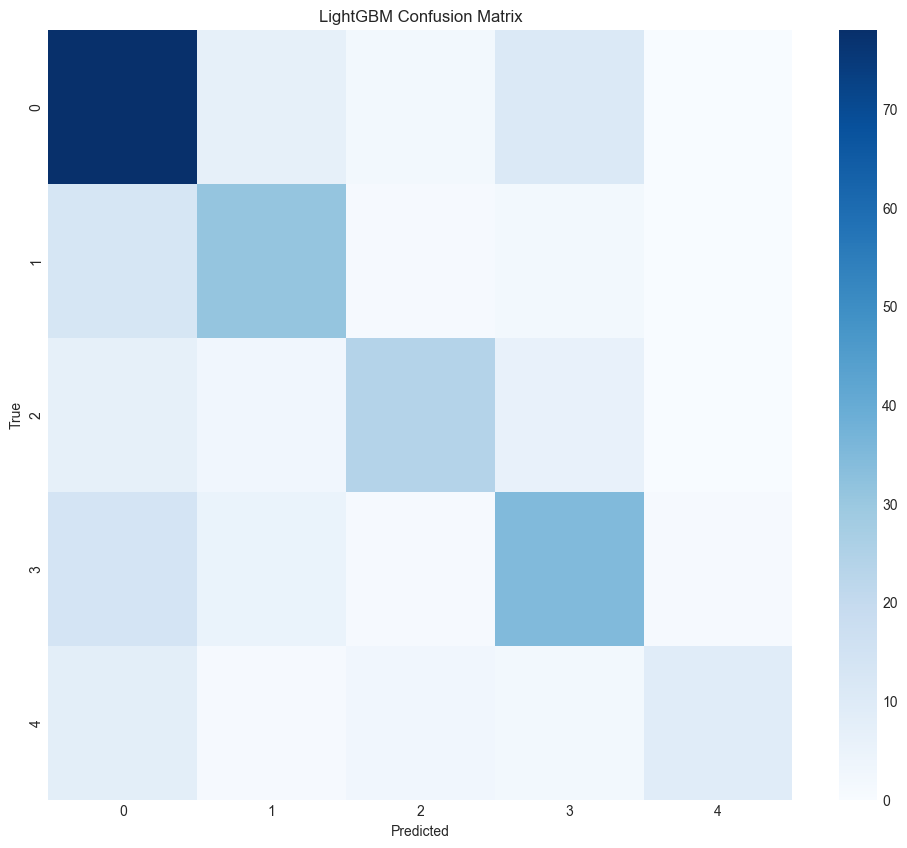

In [31]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues")
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


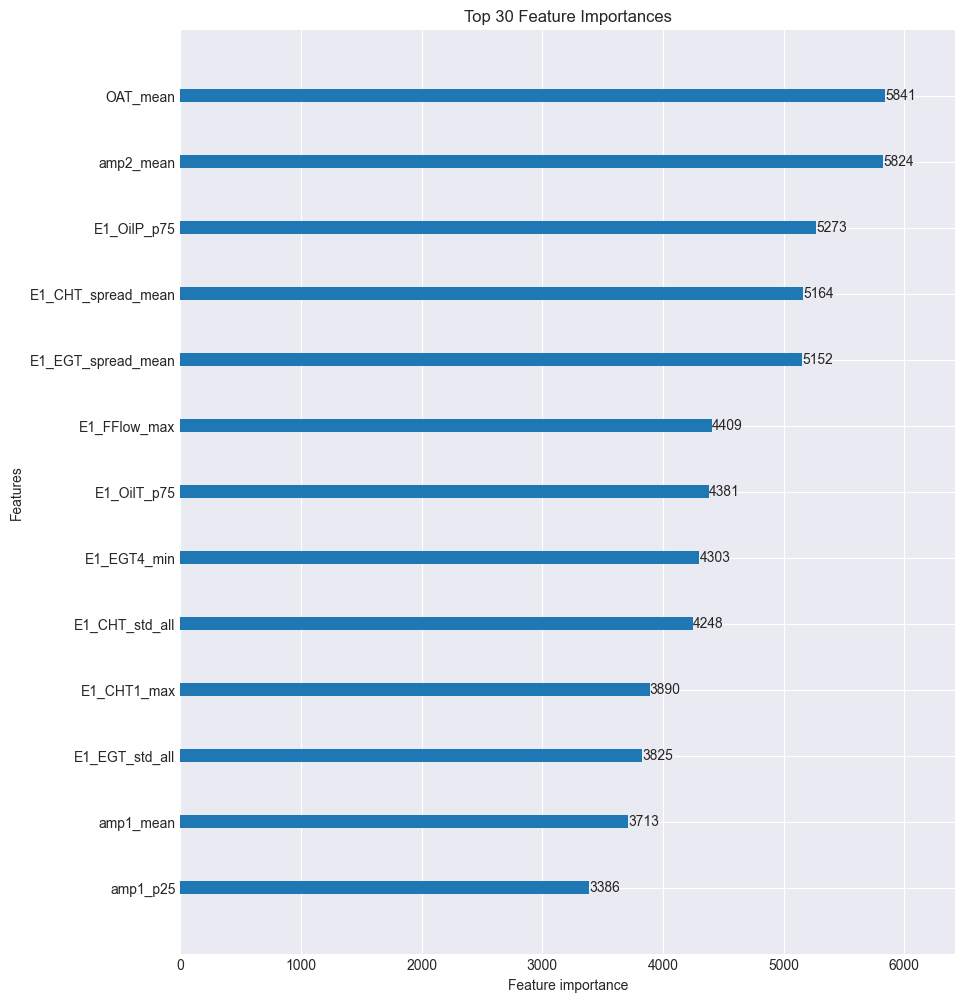

In [32]:
lgb.plot_importance(lgbmodel, max_num_features=30, figsize=(10, 12))
plt.title("Top 30 Feature Importances")
plt.show()


In [42]:
import shap
explainer = shap.TreeExplainer(lgbmodel, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_train_optimal)

In [ ]:
def explain_flight(flight_index):

    
    row = X_test_optimal.iloc[flight_index:flight_index+1]
    true_label = le.inverse_transform([y_test[flight_index]])[0]

    # Predict
    pred_proba = lgbmodel.predict(row)[0]
    pred_class = np.argmax(pred_proba)
    pred_label = le.inverse_transform([pred_class])[0]

    
    shap_vals = explainer.shap_values(row) 


    shap_for_class = shap_vals[pred_class][0]

    
    top_idx = np.argsort(np.abs(shap_for_class))[-7:][::-1]
    top_features = X_test_optimal.columns[top_idx]
    top_values = row.values.flatten()[top_idx]
    top_shaps = shap_for_class[top_idx]

    print("\n==============================================")
    print(f"FLIGHT INDEX: {flight_index}")
    print("----------------------------------------------")
    print(f"Predicted Issue: {pred_label}")
    print(f"True Issue:      {true_label}")
    print("----------------------------------------------")
    print("Top Contributing Features:")
    for f, v, s in zip(top_features, top_values, top_shaps):
        print(f"  - {f}: value={v} | SHAP={s}")
    print("==============================================\n")


In [47]:
explain_flight(7)


FLIGHT INDEX: 7
----------------------------------------------
Predicted Issue: 4
True Issue:      4
----------------------------------------------
Top Contributing Features:
  - E1_CHT_std_all: value=0.8267018364901134 | SHAP=0.47490085539998544
  - E1_EGT_spread_mean: value=25.217167966476545 | SHAP=0.26272588514009243
  - E1_EGT4_min: value=802.8 | SHAP=-0.2303126110962144
  - E1_CHT1_max: value=381.96 | SHAP=-0.1451054732175645
  - E1_CHT_spread_mean: value=24.85175648934932 | SHAP=-0.1318096858081985

